In [2]:
#imports
#numpy,pandas,scipy, math, matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report
#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
#cross validation
from sklearn.model_selection import train_test_split 

# Importing data

In [3]:
#Whole dataset
df=pd.read_csv("C:\\Users\\domsi\\OneDrive\\Documents\\M4\\UJIndoorLoc\\trainingData.csv")

#Validation dataset
valid_df=pd.read_csv("C:\\Users\\domsi\\OneDrive\\Documents\\M4\\UJIndoorLoc\\validationData.csv")

#Removing dupes
df_dupes = df[df.duplicated()]
df_2=df.drop_duplicates()

#Changing the varible types for the columns
cols_cat = ['FLOOR', 'BUILDINGID', 'SPACEID','RELATIVEPOSITION', 'USERID', 'PHONEID']
df_2[cols_cat] = df_2[cols_cat].astype('category') 

C:\Users\domsi\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [171]:
df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


All EDA is in another notebook.

# Regression Models

We will now look into a regression model which we can use to try and predict the longitude and latidue of a position based on the strength of its WIFI signal.

## Feature Selection

The validation set (below) only has FLOOR and BUILDINGID as features other than the 520 WAPs. This means we can only use these features going forward.

In [4]:
valid_df.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [5]:
#Creating copies of datasets to manipulate.
df_reg=df_2.copy()
valid_df_reg = valid_df.copy()

I will change the current WAP readings from -105 being the weakest, 0 the strongest and 100 as null value to 0 (no reading) to 105 (strongest).

In [6]:
#Reblabelling values '100' (no singal) to -106
wifi_dict_reg = {100:-106}

#Change the WAP values according to the dictionary above
df_reg.iloc[:,:520]=df_reg.iloc[:,:520].replace(wifi_dict_reg)
valid_df_reg.iloc[:,:520]=valid_df_reg.iloc[:,:520].replace(wifi_dict_reg)

#Add 106 to all WAP values
df_reg.iloc[:,:520]=df_reg.iloc[:,:520] + 106
valid_df_reg.iloc[:,:520]=valid_df_reg.iloc[:,:520] + 106

In [7]:
#Real results from the validation set to compare all predictions with later
#Lat & Long
valid_df_long_lat = valid_df_reg[['LONGITUDE','LATITUDE']]

#Re formatting the dataframe to fit the model (moving a column to the correct order), this could be done a lot cleaner
valid_df_results_FLOOR = valid_df_reg['FLOOR']
valid_df_results=valid_df_reg.drop(columns=['LONGITUDE', 'LATITUDE', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP','FLOOR'])
valid_df_results['FLOOR'] = valid_df_results_FLOOR

In [8]:
#Defining the independant and dependant variables for the regression models

#Indep = WAPS + Building + Floor, dep = Long & lat
indep_var_regression_long = df_reg.iloc[:,:520].merge(df_reg[['BUILDINGID','FLOOR']], left_index=True,right_index=True)
indep_var_regression_lat = df_reg.iloc[:,:520].merge(df_reg[['BUILDINGID','FLOOR']], left_index=True,right_index=True)

dep_var_regression_long = df_reg['LONGITUDE'] 
dep_var_regression_lat = df_reg['LATITUDE'] 

#We will try the below regression models to determine which predicts best
algos_Class_regression = []
algos_Class_regression.append(('Linear Regression',LinearRegression()))
algos_Class_regression.append(('Random Forest Regression',RandomForestRegressor()))
algos_Class_regression.append(('Decision Tree Regression', DecisionTreeRegressor()))
algos_Class_regression.append(('K Nearest Neighbours Regression', KNeighborsRegressor()))
algos_Class_regression.append(('Support Vector Machine', SVR()))

In [9]:
#We can check the average cross validation score across our models 

#longitude
results_reg_long = []
names_reg_long = []
for name, model in algos_Class_regression:
    result = cross_val_score(model, indep_var_regression_long, dep_var_regression_long, cv=3)
    names_reg_long.append(name)
    results_reg_long.append(result)

for i in range(len(names_reg_long)):
    print(names_reg_long[i],results_reg_long[i].mean())
    
#Creating our test/train split in the data to use in our longitude models.
indep_var_regression_long_train, indep_var_regression_long_test, dep_var_regression_long_train, dep_var_regression_long_test = train_test_split(indep_var_regression_long, dep_var_regression_long, test_size = .30, random_state = 123)

Linear Regression -8.813139264323083e+18
Random Forest Regression 0.9665228156041618
Decision Tree Regression 0.9396933218140483
K Nearest Neighbours Regression 0.9031869846273164
Support Vector Machine 0.7929296265336016


In [15]:
#latitude
results_reg_lat = []
names_reg_lat = []
for name, model in algos_Class_regression:
    result = cross_val_score(model, indep_var_regression_lat, dep_var_regression_lat, cv=3)
    names_reg_lat.append(name)
    results_reg_lat.append(result)
    
for i in range(len(names_reg_lat)):
    print(names_reg_lat[i],results_reg_lat[i].mean())
    
#creating the test/train split for Latitude
indep_var_regression_lat_train, indep_var_regression_lat_test, dep_var_regression_lat_train, dep_var_regression_lat_test = train_test_split(indep_var_regression_lat, dep_var_regression_lat, test_size = .30, random_state = 123)

Linear Regression -4.2618746640199215e+20
Random Forest Regression 0.9273826564404125
Decision Tree Regression 0.8987505756328145
K Nearest Neighbours Regression 0.8740408856533411
Support Vector Machine 0.694210626831715


We will exclude testing Linear Regression, it does not fit for this scenario.

### Random Forest

In [10]:
#Longitude
algo_RF_reg_long = RandomForestRegressor() #Define the algo
model_RF_reg_long = algo_RF_reg_long.fit(indep_var_regression_long_train,dep_var_regression_long_train) #Fit the model
prediction_RF_reg_long = model_RF_reg_long.predict(indep_var_regression_long_test) #Prediction

print("MAE on Random Forest Regression train data to predict longitude = " , mean_absolute_error(dep_var_regression_long_test, prediction_RF_reg_long))
print("R squared on Random Forest Regression train data to predict longitude = " , r2_score(dep_var_regression_long_test, prediction_RF_reg_long))
print("MSE on Random Forest Regression train data to predict longitude= " , mean_squared_error(dep_var_regression_long_test, prediction_RF_reg_long))
print("RMSE on Random Forest Regression train data to predict longitude= " , mean_squared_error(dep_var_regression_long_test, prediction_RF_reg_long,squared=False))

#Saving the errors to assess later
RF_long_errors=[mean_absolute_error(dep_var_regression_long_test, prediction_RF_reg_long),r2_score(dep_var_regression_long_test, prediction_RF_reg_long),mean_squared_error(dep_var_regression_long_test, prediction_RF_reg_long),
               mean_squared_error(dep_var_regression_long_test, prediction_RF_reg_long,squared=False)]

MAE on Random Forest Regression train data =  2.1990196623225375
R squared on Random Forest Regression train data =  0.9987014021182196
MSE on Random Forest Regression train data =  20.056654844653433
RMSE on Random Forest Regression train data =  4.4784656797449545


In [16]:
#latitude
algo_RF_reg_lat = RandomForestRegressor()
model_RF_reg_lat = algo_RF_reg_lat.fit(indep_var_regression_lat_train,dep_var_regression_lat_train)
prediction_RF_reg_lat = model_RF_reg_lat.predict(indep_var_regression_lat_test)

print("MAE on Random Forest Regression train data to predict latitude = " , mean_absolute_error(dep_var_regression_lat_test, prediction_RF_reg_lat))
print("R squared on Random Forest Regression train data to predict latitude = " , r2_score(dep_var_regression_lat_test, prediction_RF_reg_lat))
print("MSE on Random Forest Regression train data to predict latitude = " , mean_squared_error(dep_var_regression_lat_test, prediction_RF_reg_lat))
print("RMSE on Random Forest Regression train data to predict latitude = " , mean_squared_error(dep_var_regression_lat_test, prediction_RF_reg_lat,squared=False))

#Save the errors
RF_lat_errors=[mean_absolute_error(dep_var_regression_lat_test, prediction_RF_reg_lat),r2_score(dep_var_regression_lat_test, prediction_RF_reg_lat),mean_squared_error(dep_var_regression_lat_test, prediction_RF_reg_lat),
              mean_squared_error(dep_var_regression_lat_test, prediction_RF_reg_lat,squared=False)]

MAE on Random Forest Regression train data =  2.006761738370512
R squared on Random Forest Regression train data =  0.9964064727719331
MSE on Random Forest Regression train data =  16.496656182479253
RMSE on Random Forest Regression train data =  4.061607585978642


### Decision Tree

In [11]:
algo_DT_reg_long = DecisionTreeRegressor()
model_DT_reg_long = algo_DT_reg_long.fit(indep_var_regression_long_train,dep_var_regression_long_train)
prediction_DT_reg_long = model_DT_reg_long.predict(indep_var_regression_long_test)

print("MAE on Decision Tree Regression train data to predict longitude = " , mean_absolute_error(dep_var_regression_long_test, prediction_DT_reg_long))
print("R squared on Decision Tree Regression train data to predict longitude = " , r2_score(dep_var_regression_long_test, prediction_DT_reg_long))
print("MSE on Decision Tree Regression  train data to predict longitude = " , mean_squared_error(dep_var_regression_long_test, prediction_DT_reg_long))
print("RMSE on Decision Tree Regression  train data to predict longitude = " , mean_squared_error(dep_var_regression_long_test, prediction_DT_reg_long,squared=False))

#Saving the errors to assess later
DT_long_errors=[mean_absolute_error(dep_var_regression_long_test, prediction_DT_reg_long),r2_score(dep_var_regression_long_test, prediction_DT_reg_long),mean_squared_error(dep_var_regression_long_test, prediction_DT_reg_long),
               mean_squared_error(dep_var_regression_long_test, prediction_DT_reg_long,squared=False)]

MAE on Decision Tree Regression train data=  2.583301774780804
R squared on Decision Tree Regression train data =  0.9969109121758682
MSE on Decision Tree Regression  train data =  47.710510807613694
RMSE on Decision Tree Regression  train data =  6.907279551865097


In [17]:
algo_DT_reg_lat = DecisionTreeRegressor()
model_DT_reg_lat = algo_DT_reg_lat.fit(indep_var_regression_lat_train,dep_var_regression_lat_train)
prediction_DT_reg_lat = model_DT_reg_lat.predict(indep_var_regression_lat_test)

print("MAE on Decision Tree Regression train data to predict latitude= " , mean_absolute_error(dep_var_regression_lat_test, prediction_DT_reg_lat))
print("R squared on Decision Tree Regression train data to predict latitude= " , r2_score(dep_var_regression_lat_test, prediction_DT_reg_lat))
print("MSE on Decision Tree Regression train data to predict latitude= " , mean_squared_error(dep_var_regression_lat_test, prediction_DT_reg_lat))
print("RMSE on Decision Tree Regression train data to predict latitude= " , mean_squared_error(dep_var_regression_lat_test, prediction_DT_reg_lat, squared=False))

#Saving the errors
DT_lat_errors=[mean_absolute_error(dep_var_regression_lat_test, prediction_DT_reg_lat),r2_score(dep_var_regression_lat_test, prediction_DT_reg_lat),mean_squared_error(dep_var_regression_lat_test, prediction_DT_reg_lat),
              mean_squared_error(dep_var_regression_lat_test, prediction_DT_reg_lat,squared=False)]

MAE on Decision Tree Regression train data=  2.2144372268230854
R squared on Decision Tree Regression train data =  0.9928811471205736
MSE on Decision Tree Regression  train data =  32.68022221963907
RMSE on Decision Tree Regression  train data =  5.716661807352178


### K Nearest Neighbours

In [12]:
algo_KN_reg_long = KNeighborsRegressor()
model_KN_reg_long = algo_KN_reg_long.fit(indep_var_regression_long_train,dep_var_regression_long_train)
prediction_KN_reg_long = model_KN_reg_long.predict(indep_var_regression_long_test)

print("MAE on K Nearest Neighbours Regression train data to predict longitude= " , mean_absolute_error(dep_var_regression_long_test, prediction_KN_reg_long))
print("R squared on K Nearest NeighboursRegression train data to predict longitude= " , r2_score(dep_var_regression_long_test, prediction_KN_reg_long))
print("MSE on K Nearest Neighbours Regression train data to predict longitude= " , mean_squared_error(dep_var_regression_long_test, prediction_KN_reg_long))
print("RMSE on K Nearest Neighbours Regression train data to predict longitude= " , mean_squared_error(dep_var_regression_long_test, prediction_KN_reg_long,squared=False))
#Saving the errors to assess later
KN_long_errors=[mean_absolute_error(dep_var_regression_long_test, prediction_KN_reg_long),r2_score(dep_var_regression_long_test, prediction_KN_reg_long),mean_squared_error(dep_var_regression_long_test, prediction_KN_reg_long),mean_squared_error(dep_var_regression_long_test, prediction_KN_reg_long,squared=False)]

MAE on K Nearest Neighbours Regression train data=  1.8497344504102078
R squared on K Nearest NeighboursRegression train data =  0.9986554740768938
MSE on K Nearest Neighbours Regression  train data =  20.766006742946534
RMSE on K Nearest Neighbours Regression  train data =  4.556973419161729


In [18]:
algo_KN_reg_lat = KNeighborsRegressor()
model_KN_reg_lat = algo_KN_reg_lat.fit(indep_var_regression_lat_train,dep_var_regression_lat_train)
prediction_KN_reg_lat = model_KN_reg_lat.predict(indep_var_regression_lat_test)

print("MAE on K Nearest Neighbours Regression train data to predict latitude = " , mean_absolute_error(dep_var_regression_lat_test, prediction_KN_reg_lat))
print("R squared on K Nearest NeighboursRegression train data to predict latitude = " , r2_score(dep_var_regression_lat_test, prediction_KN_reg_lat))
print("MSE on K Nearest Neighbours Regression train data to predict latitude = " , mean_squared_error(dep_var_regression_lat_test, prediction_KN_reg_lat))
print("RMSE on K Nearest Neighbours Regression train data to predict latitude = " , mean_squared_error(dep_var_regression_lat_test, prediction_KN_reg_lat,squared=False))

#Save the errors
KN_lat_errors=[mean_absolute_error(dep_var_regression_lat_test, prediction_KN_reg_lat),r2_score(dep_var_regression_lat_test, prediction_KN_reg_lat),mean_squared_error(dep_var_regression_lat_test, prediction_KN_reg_lat),
              mean_squared_error(dep_var_regression_lat_test, prediction_KN_reg_lat,squared=False)]

MAE on K Nearest Neighbours Regression train data=  1.5683369536272898
R squared on K Nearest NeighboursRegression train data =  0.9971883328525457
MSE on K Nearest Neighbours Regression  train data =  12.907403586330124
RMSE on K Nearest Neighbours Regression  train data =  3.592687515820173


### SVM

In [13]:
algo_SVM_reg_long = SVR()
model_SVM_reg_long = algo_SVM_reg_long.fit(indep_var_regression_long_train,dep_var_regression_long_train)
prediction_SVM_reg_long = model_SVM_reg_long.predict(indep_var_regression_long_test)

print("MAE on Support Vector Regression train data to predict longitude= " , mean_absolute_error(dep_var_regression_long_test, prediction_SVM_reg_long))
print("R squared on Support Vector Regression train data to predict longitude= " , r2_score(dep_var_regression_long_test, prediction_SVM_reg_long))
print("MSE on Support Vector Regression  train data to predict longitude= " , mean_squared_error(dep_var_regression_long_test, prediction_SVM_reg_long))
print("RMSE on Support VectorRegression  train data to predict longitude= " , mean_squared_error(dep_var_regression_long_test, prediction_SVM_reg_long,squared=False))

#Saving the errors to assess later
SVM_long_errors=[mean_absolute_error(dep_var_regression_long_test, prediction_SVM_reg_long),r2_score(dep_var_regression_long_test, prediction_SVM_reg_long),mean_squared_error(dep_var_regression_long_test, prediction_SVM_reg_long),
                 mean_squared_error(dep_var_regression_long_test, prediction_SVM_reg_long,squared=False)]

MAE on Support Vector Regression train data=  15.348007770771158
R squared on Support Vector Regression train data =  0.9635932352474476
MSE on Support Vector Regression  train data =  562.297170584696
RMSE on Support VectorRegression  train data =  23.71280604619993


In [19]:
algo_SVM_reg_lat = SVR()
model_SVM_reg_lat = algo_SVM_reg_lat.fit(indep_var_regression_lat_train,dep_var_regression_lat_train)
prediction_SVM_reg_lat = model_SVM_reg_lat.predict(indep_var_regression_lat_test)

print("MAE on Support Vector Regression train data to predict latitude= " , mean_absolute_error(dep_var_regression_lat_test, prediction_SVM_reg_lat))
print("R squared on Support Vector Regression train data to predict latitude= " , r2_score(dep_var_regression_lat_test, prediction_SVM_reg_lat))
print("MSE on Support Vector Regression train data to predict latitude= " , mean_squared_error(dep_var_regression_lat_test, prediction_SVM_reg_lat))
print("RMSE on Support Vector Regression train data to predict latitude= " , mean_squared_error(dep_var_regression_lat_test, prediction_SVM_reg_lat,squared=False))

#Save the errors
SVM_lat_errors=[mean_absolute_error(dep_var_regression_lat_test, prediction_SVM_reg_lat),r2_score(dep_var_regression_lat_test, prediction_SVM_reg_lat),mean_squared_error(dep_var_regression_lat_test, prediction_SVM_reg_lat),
              mean_squared_error(dep_var_regression_lat_test, prediction_SVM_reg_lat,squared=False)]

MAE on Support Vector Regression train data=  8.582613279717446
R squared on Support Vector Regression train data =  0.9593759325874399
MSE on Support Vector Regression train data =  186.49121887949954
RMSE on Support Vector Regression train data =  13.656178780299397


### Error comparisons

In [14]:
#Creating a dataframe to compare the errors across all models.
models_list=['Random Forest', 'Decision Tree','K Nearest Neighbours','Support Vector Machine']
error_stat=['MAE','R Squared', 'MSE','RMSE']
df_error_comp_long=pd.DataFrame(columns=models_list, index=error_stat
                        )
df_error_comp_long['Random Forest']=RF_long_errors
df_error_comp_long['Decision Tree'] = DT_long_errors
df_error_comp_long['K Nearest Neighbours'] = KN_long_errors
df_error_comp_long['Support Vector Machine'] = SVM_long_errors

print(df_error_comp_long)

           Random Forest  Decision Tree  K Nearest Neighbours  \
MAE             2.199020       2.583302              1.849734   
R Squared       0.998701       0.996911              0.998655   
MSE            20.056655      47.710511             20.766007   
RMSE            4.478466       6.907280              4.556973   

           Support Vector Machine  
MAE                     15.348008  
R Squared                0.963593  
MSE                    562.297171  
RMSE                    23.712806  


In [20]:
df_error_comp_lat=pd.DataFrame(columns=models_list, index=error_stat
                        )
df_error_comp_lat['Random Forest']=RF_lat_errors
df_error_comp_lat['Decision Tree'] = DT_lat_errors
df_error_comp_lat['K Nearest Neighbours'] = KN_lat_errors
df_error_comp_lat['Support Vector Machine'] = SVM_lat_errors

print(df_error_comp_lat)

           Random Forest  Decision Tree  K Nearest Neighbours  \
MAE             2.006762       2.214437              1.568337   
R Squared       0.996406       0.992881              0.997188   
MSE            16.496656      32.680222             12.907404   
RMSE            4.061608       5.716662              3.592688   

           Support Vector Machine  
MAE                      8.582613  
R Squared                0.959376  
MSE                    186.491219  
RMSE                    13.656179  


Random Forest and K Nearest Neighbours have minimised the errors to the greatest extent.

## Predictions on validation set

### Random Forest

In [128]:
#Long and Lat predictions
prediction_RF_reg_long_valid_df = model_RF_reg_long.predict(valid_df_results)
prediction_RF_reg_lat_valid_df = model_RF_reg_lat.predict(valid_df_results)

#Creating a DF to compare predicitions
compare_dict={'Real Long':valid_df_long_lat['LONGITUDE'],
              'RF Long Pred':pd.Series(prediction_RF_reg_long_valid_df),
              'Real lat': valid_df_long_lat['LATITUDE'], 
              'RF Lat Pred':pd.Series(prediction_RF_reg_lat_valid_df)}

pred_compare_df=pd.DataFrame(compare_dict)

pred_compare_df['Long Error'] = pred_compare_df['Real Long'] - pred_compare_df['RF Long Pred']
pred_compare_df['Lat Error'] = pred_compare_df['Real lat'] - pred_compare_df['RF Lat Pred']

print("MAE on RF Regression validation data predicting Latitude = " , mean_absolute_error(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred']))
print("R squared on RF Regression validation data predicting Latitude = " , r2_score(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred']))
print("MSE on RF Regression validation data predicting Latitude = " , mean_squared_error(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred']))
print("RMSE on RF Regression validation data predicting Latitude = " , mean_squared_error(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred'],squared=False))

RF_valid_lat_errors=[mean_absolute_error(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred']),r2_score(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred']),mean_squared_error(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred']),
               mean_squared_error(pred_compare_df['Real lat'], pred_compare_df['RF Lat Pred'],squared=False)]
print('\n')
print("MAE on RF Regression validation data predicting Longitude = " , mean_absolute_error(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred']))
print("R squared on RF Regression validation data predicting Longitude = " , r2_score(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred']))
print("MSE on RF Regression validation data predicting Longitude = " , mean_squared_error(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred']))
print("RMSE on RF Regression validation data predicting Longitude = " , mean_squared_error(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred'],squared=False))

RF_valid_long_errors=[mean_absolute_error(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred']),r2_score(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred']),mean_squared_error(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred']),
               mean_squared_error(pred_compare_df['Real Long'], pred_compare_df['RF Long Pred'],squared=False)]

MAE on RF Regression validation data predicting Latitude =  6.498629585021653
R squared on RF Regression validation data predicting Latitude =  0.9794462494352625
MSE on RF Regression validation data predicting Latitude =  101.40853538182547
RMSE on RF Regression validation data predicting Latitude =  10.070180503934647


MAE on RF Regression validation data predicting Longitude =  6.5493703689261915
R squared on RF Regression validation data predicting Longitude =  0.9931163401030292
MSE on RF Regression validation data predicting Longitude =  99.38131078327503
RMSE on RF Regression validation data predicting Longitude =  9.969017543533315


### K Nearest Neighbours

In [129]:
#Long and Lat predictions
prediction_KN_reg_long_valid_df = model_KN_reg_long.predict(valid_df_results)
prediction_KN_reg_lat_valid_df = model_KN_reg_lat.predict(valid_df_results)

#Creating a DF to compare predicitions
compare_dict_KN={'Real Long':valid_df_long_lat['LONGITUDE'],
              'KN Long Pred':pd.Series(prediction_KN_reg_long_valid_df),
              'Real lat': valid_df_long_lat['LATITUDE'], 
              'KN Lat Pred':pd.Series(prediction_KN_reg_lat_valid_df)}

pred_compare_df_KN=pd.DataFrame(compare_dict_KN)

pred_compare_df_KN['Long Error'] = pred_compare_df_KN['Real Long'] - pred_compare_df_KN['KN Long Pred']
pred_compare_df_KN['Lat Error'] = pred_compare_df_KN['Real lat'] - pred_compare_df_KN['KN Lat Pred']

print("MAE on KN Regression validation data predicting Latitude = " , mean_absolute_error(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred']))
print("R squared on KN Regression validation data predicting Latitude = " , r2_score(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred']))
print("MSE on KN Regression validation data predicting Latitude = " , mean_squared_error(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred']))
print("RMSE on KN Regression validation data predicting Latitude = " , mean_squared_error(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred'],squared=False))

KN_valid_lat_errors=[mean_absolute_error(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred']),r2_score(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred']),mean_squared_error(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred']),
               mean_squared_error(pred_compare_df_KN['Real lat'], pred_compare_df_KN['KN Lat Pred'],squared=False)]
print('\n')
print("MAE on KN Regression validation data predicting Longitude = " , mean_absolute_error(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred']))
print("R squared on KN Regression validation data predicting Longitude = " , r2_score(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred']))
print("MSE on KN Regression validation data predicting Longitude = " , mean_squared_error(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred']))
print("RMSE on KN Regression validation data predicting Longitude = " , mean_squared_error(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred'],squared=False))

KN_valid_long_errors=[mean_absolute_error(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred']),r2_score(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred']),mean_squared_error(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred']),
               mean_squared_error(pred_compare_df_KN['Real Long'], pred_compare_df_KN['KN Long Pred'],squared=False)]

MAE on KN Regression validation data predicting Latitude =  5.690228532906706
R squared on KN Regression validation data predicting Latitude =  0.9708035296829614
MSE on KN Regression validation data predicting Latitude =  144.05017146843286
RMSE on KN Regression validation data predicting Latitude =  12.002090295795682


MAE on KN Regression validation data predicting Longitude =  6.513229864852181
R squared on KN Regression validation data predicting Longitude =  0.9832756361561437
MSE on KN Regression validation data predicting Longitude =  241.4542882268587
RMSE on KN Regression validation data predicting Longitude =  15.538799446123845


In [137]:
#Defining the labels for error comparison
reg_model=['Random Forest','K Nearest Neighbours']
error_stat=['MAE','R Squared', 'MSE','RMSE']

df_valid_error_comp_lat=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_valid_error_comp_long=pd.DataFrame(columns=reg_model, index=error_stat
                        )

df_valid_error_comp_lat['Random Forest']=RF_valid_lat_errors
df_valid_error_comp_lat['K Nearest Neighbours'] = KN_valid_lat_errors
df_valid_error_comp_long['Random Forest']=RF_valid_long_errors
df_valid_error_comp_long['K Nearest Neighbours'] = KN_valid_long_errors

print("Longitude Errors:")
df_valid_error_comp_long

Longitude Errors:


,Random Forest,K Nearest Neighbours
MAE,6.549370,6.513230
R Squared,0.993116,0.983276
MSE,99.381311,241.454288
RMSE,9.969018,15.538799


In [136]:
print("Latitude Errors:")
df_valid_error_comp_lat

Latitude Errors:


,Random Forest,K Nearest Neighbours
MAE,6.498630,5.690229
R Squared,0.979446,0.970804
MSE,101.408535,144.050171
RMSE,10.070181,12.002090


Text(0.5, 1.0, 'K Nearest Neighbours Predicted Values')

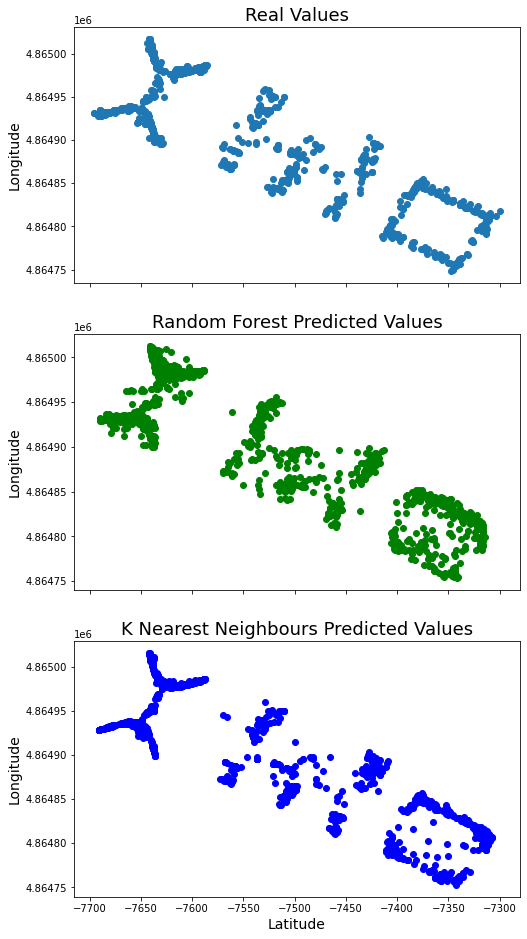

In [141]:
fig, (ax01,ax02,ax03) = plt.subplots(nrows=3,ncols=1,figsize = (8,16), sharex = True)
#fonts
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}

#x axis
plt.xlabel('Latitude',fontdict = fontdict_yaxis)

ax01.plot(valid_df_long_lat['LONGITUDE'],valid_df_long_lat['LATITUDE'],'o')
ax01.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
ax01.set_title('Real Values', fontdict= fontdict);

ax02.plot(prediction_RF_reg_long_valid_df ,prediction_RF_reg_lat_valid_df,'go')
ax02.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
ax02.set_title('Random Forest Predicted Values', fontdict= fontdict);

ax03.plot(prediction_KN_reg_long_valid_df,prediction_KN_reg_lat_valid_df,'bo')
ax03.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
ax03.set_title('K Nearest Neighbours Predicted Values', fontdict= fontdict)

# Can we guess a location from only WIFI strength?

We are going to investigate how closely we can predict a points longitude and latitude based on the Wifi singal strength. 

### Building & Floor Classification

We will start off trying to predict the Building number and floor number of a signal spot based on the WIFI signal strength registered.

In [23]:
#Creating the independant variables (WIFI SIGNALS) dataframe dependant variable (BUILDING NUMBER)
indep_var_BUILDING = df_reg.iloc[:,:520]
dep_var_BUILDING = df_reg['BUILDINGID']

#Creating the independant variables (WIFI SIGNALS + BUILDING NUMBER) dataframe dependant variable (FLOOR NUMBER)
indep_var_FLOOR = df_reg.iloc[:,:520].merge(df_reg['BUILDINGID'], left_index=True,right_index=True)
dep_var_FLOOR= df_reg['FLOOR'] 

#Defining variables to guess the building number
indep_var_BUILDING_train, indep_var_BUILDING_test,dep_var_BUILDING_train, dep_var_BUILDING_test = train_test_split(indep_var_BUILDING, 
                                                                 dep_var_BUILDING, test_size = .30,
                                                                 random_state = 123)

#Defining variables to guess the floor number
indep_var_FLOOR_train, indep_var_FLOOR_test,dep_var_FLOOR_train, dep_var_FLOOR_test = train_test_split(indep_var_FLOOR, dep_var_FLOOR,
                                                           test_size = .30, random_state = 123)

### Random Forest Classifier to predict Building & Floor

In [24]:
#Define the classifying algos
algo_RF_B = RandomForestClassifier() 
algo_RF_F = RandomForestClassifier() 

#Fit the algo to our independant & dependant (BUILDING) var training set
model_RF_BUILDING = algo_RF_B.fit(indep_var_BUILDING_train,dep_var_BUILDING_train)

#Fit the algo to our independant & dependant (FLOOR) var training set
model_RF_FLOOR = algo_RF_F.fit(indep_var_FLOOR_train,dep_var_FLOOR_train)

#Prediction of the building number on our unseen test set
prediction_RF_BUILDING = model_RF_BUILDING.predict(indep_var_BUILDING_test)

#Prediction of the floor number on our unseen test set
prediction_RF_FLOOR = model_RF_FLOOR.predict(indep_var_FLOOR_test)

In [25]:
print("Almost 100% accuracy in guessing the building number based off the wifi singals:")
print(classification_report(dep_var_BUILDING_test, prediction_RF_BUILDING))

Almost 100% accuracy in guessing the building number based off the wifi singals:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1584
           1       1.00      0.99      1.00      1460
           2       1.00      1.00      1.00      2746

    accuracy                           1.00      5790
   macro avg       1.00      1.00      1.00      5790
weighted avg       1.00      1.00      1.00      5790



In [26]:
print("Almost 100% accuracy in guessing the Floor number based off the wifi singals & building number:")
print(classification_report(dep_var_FLOOR_test, prediction_RF_FLOOR))

Almost 100% accuracy in guessing the Floor number based off the wifi singals & building number:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1284
           1       1.00      1.00      1.00      1417
           2       1.00      1.00      1.00      1318
           3       1.00      1.00      1.00      1555
           4       1.00      1.00      1.00       216

    accuracy                           1.00      5790
   macro avg       1.00      1.00      1.00      5790
weighted avg       1.00      1.00      1.00      5790



We have an extremely high accuracy in predicting which building and floor each data point was recorded on.

## Regression models for Long/Lat based on buildings

We will now use our predictions for the building and floor to formulate a longitude and latitude for each data point.

A each building defines a longitude and latitude boundary, we will train models individually to try and make the predictions as accurate as possible.

In [27]:
#Creating seperate dataframes for each building, we will use these sets to train our regression models 
B_0_df_reg = df_reg[df_reg['BUILDINGID']==0]
B_1_df_reg = df_reg[df_reg['BUILDINGID']==1]
B_2_df_reg = df_reg[df_reg['BUILDINGID']==2]

### Building 0

In [28]:
#Defining our independant variables for Longitude and Latitude

#Longitude
indep_var_regression_long_b0 = B_0_df_reg.iloc[:,:520].merge(B_0_df_reg['FLOOR'], left_index=True,right_index=True)
dep_var_regression_long_b0 = B_0_df_reg['LONGITUDE'] 

#Latitude
indep_var_regression_lat_b0 = B_0_df_reg.iloc[:,:520].merge(B_0_df_reg['FLOOR'], left_index=True,right_index=True)
dep_var_regression_lat_b0 = B_0_df_reg['LATITUDE'] 

#Creating our test/train split independant and dependant variables
indep_var_regression_long_b0_train, indep_var_regression_long_b0_test, dep_var_regression_long_b0_train,dep_var_regression_long_b0_test = train_test_split(indep_var_regression_long_b0, dep_var_regression_long_b0,test_size = .30, random_state = 123)
indep_var_regression_lat_b0_train, indep_var_regression_lat_b0_test, dep_var_regression_lat_b0_train,dep_var_regression_lat_b0_test = train_test_split(indep_var_regression_lat_b0, dep_var_regression_lat_b0, test_size = .30, random_state = 123)

#### Random Forest

###### Longitude

In [29]:
algo_RF_reg_long2= RandomForestRegressor() #Define the algo
model_RF_reg_b0_long = algo_RF_reg_long2.fit(indep_var_regression_long_b0_train,
                                             dep_var_regression_long_b0_train) #fit the model
prediction_RF_reg_b0_long = model_RF_reg_b0_long.predict(indep_var_regression_long_b0_test) #Prediction

In [30]:
print("MAE on Random Forest Regression train data (Building 0) = " , mean_absolute_error(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long))
print("R squared on Random Forest Regression train data (Building 0) = " , r2_score(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long))
print("MSE on Random Forest Regression train data (Building 0) = " , mean_squared_error(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long))
print("RMSE on Random Forest Regression train data (Building 0) = " , mean_squared_error(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long,squared=False))

RF_long_b0_errors=[mean_absolute_error(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long),r2_score(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long),mean_squared_error(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long),
               mean_squared_error(dep_var_regression_long_b0_test, prediction_RF_reg_b0_long,squared=False)]

MAE on Random Forest Regression train data (Building 0) =  1.8432651662715251
R squared on Random Forest Regression train data (Building 0) =  0.9803200082051076
MSE on Random Forest Regression train data (Building 0) =  12.480561139874567
RMSE on Random Forest Regression train data (Building 0) =  3.532783766362522


###### Latitude

In [31]:
algo_RF_reg_lat2 = RandomForestRegressor() # Define the algo
model_RF_reg_b0_lat = algo_RF_reg_lat2.fit(indep_var_regression_lat_b0_train,
                                           dep_var_regression_lat_b0_train) # fit the model
prediction_RF_reg_b0_lat = model_RF_reg_b0_lat.predict(indep_var_regression_lat_b0_test) # Prediciton

In [32]:
print("MAE on Random Forest Regression train data predicting Latitude (Building 0) = " , mean_absolute_error(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat))
print("R squared on Random Forest Regression train data predicting Latitude (Building 0) = " , r2_score(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat))
print("MSE on Random Forest Regression train data predicting Latitude (Building 0) = " , mean_squared_error(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat))
print("RMSE on Random Forest Regression train data predicting Latitude (Building 0) = " , mean_squared_error(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat,squared=False))

RF_lat_b0_errors=[mean_absolute_error(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat),r2_score(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat),mean_squared_error(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat),
               mean_squared_error(dep_var_regression_lat_b0_test, prediction_RF_reg_b0_lat,squared=False)]

MAE on Random Forest Regression train data predicting Latitude (Building 0) =  1.4568609967520116
R squared on Random Forest Regression train data predicting Latitude (Building 0) =  0.9942731164777896
MSE on Random Forest Regression train data predicting Latitude (Building 0) =  6.1634306826923515
RMSE on Random Forest Regression train data predicting Latitude (Building 0) =  2.482625763721216


#### K Nearest Neighbours

###### Longitude

In [33]:
algo_KN_reg_long2 = KNeighborsRegressor()
model_KN_reg_b0_long = algo_KN_reg_long2.fit(indep_var_regression_long_b0_train,
                                             dep_var_regression_long_b0_train)
prediction_KN_reg_b0_long = model_KN_reg_b0_long.predict(indep_var_regression_long_b0_test)

In [34]:
print("MAE on K Nearest Neighbours Regression train data (Building 0) = " , mean_absolute_error(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long))
print("R squared on K Nearest Neighbours Regression train data (Building 0) = " , r2_score(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long))
print("MSE on K Nearest Neighbours Regression train data (Building 0) = " , mean_squared_error(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long))
print("RMSE on K Nearest Neighbours Regression train data (Building 0) = " , mean_squared_error(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long,squared=False))

KN_long_b0_errors=[mean_absolute_error(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long),r2_score(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long),mean_squared_error(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long),
               mean_squared_error(dep_var_regression_long_b0_test, prediction_KN_reg_b0_long,squared=False)]

MAE on K Nearest Neighbours Regression train data (Building 0) =  1.552031373670978
R squared on K Nearest Neighbours Regression train data (Building 0) =  0.9842221453762703
MSE on K Nearest Neighbours Regression train data (Building 0) =  10.005922834714658
RMSE on K Nearest Neighbours Regression train data (Building 0) =  3.1632140039388195


###### Latitude

In [35]:
algo_KN_reg_lat2= KNeighborsRegressor()
model_KN_reg_b0_lat = algo_KN_reg_lat2.fit(indep_var_regression_lat_b0_train,
                                           dep_var_regression_lat_b0_train)
prediction_KN_reg_b0_lat = model_KN_reg_b0_lat.predict(indep_var_regression_lat_b0_test)

In [36]:
print("MAE on K Nearest Neighbours Regression train data predicting Latitude (Building 0) = " , mean_absolute_error(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat))
print("R squared on K Nearest Neighbours Regression train data predicting Latitude (Building 0) = " , r2_score(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat))
print("MSE on K Nearest Neighbours Regression train data predicting Latitude (Building 0) = " , mean_squared_error(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat))
print("RMSE on K Nearest Neighbours Regression train data predicting Latitude (Building 0) = " , mean_squared_error(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat,squared=False))

KN_lat_b0_errors=[mean_absolute_error(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat),r2_score(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat),mean_squared_error(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat),
               mean_squared_error(dep_var_regression_lat_b0_test, prediction_KN_reg_b0_lat,squared=False)]

MAE on K Nearest Neighbours Regression train data predicting Latitude (Building 0) =  1.400609971573186
R squared on K Nearest Neighbours Regression train data predicting Latitude (Building 0) =  0.9937302355795361
MSE on K Nearest Neighbours Regression train data predicting Latitude (Building 0) =  6.747694143327812
RMSE on K Nearest Neighbours Regression train data predicting Latitude (Building 0) =  2.5976324111251405


### Building 1

In [37]:
#Longitude
indep_var_regression_long_b1 = B_1_df_reg.iloc[:,:520].merge(B_1_df_reg['FLOOR'], left_index=True,right_index=True)
dep_var_regression_long_b1 = B_1_df_reg['LONGITUDE']

#Latitude
indep_var_regression_lat_b1 = B_1_df_reg.iloc[:,:520].merge(B_1_df_reg['FLOOR'], left_index=True,right_index=True) 
dep_var_regression_lat_b1 = B_1_df_reg['LATITUDE'] 

#Test/train split
indep_var_regression_long_b1_train, indep_var_regression_long_b1_test, dep_var_regression_long_b1_train,dep_var_regression_long_b1_test = train_test_split(indep_var_regression_long_b1, dep_var_regression_long_b1, test_size = .30, random_state = 123)
indep_var_regression_lat_b1_train, indep_var_regression_lat_b1_test, dep_var_regression_lat_b1_train,dep_var_regression_lat_b1_test = train_test_split(indep_var_regression_lat_b1, dep_var_regression_lat_b1, test_size = .30, random_state = 123)

#### Random Forest

###### Longitude

In [38]:
algo_RF_reg_b1_long = RandomForestRegressor()
model_RF_reg_b1_long = algo_RF_reg_b1_long.fit(indep_var_regression_long_b1_train,
                                               dep_var_regression_long_b1_train)
prediction_RF_reg_b1_long = model_RF_reg_b1_long.predict(indep_var_regression_long_b1_test)

In [39]:
print("MAE on Random Forest Regression train data predicting Longitude (Building 1) = " , mean_absolute_error(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long))
print("R squared on Random Forest Regression train data predicting Longitude (Building 1) = " , r2_score(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long))
print("MSE on Random Forest Regression train data predicting Longitude (Building 1) = " , mean_squared_error(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long))
print("RMSE on Random Forest Regression train data predicting Longitude (Building 1) = " , mean_squared_error(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long,squared=False))

RF_long_b1_errors=[mean_absolute_error(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long),r2_score(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long),mean_squared_error(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long),
               mean_squared_error(dep_var_regression_long_b1_test, prediction_RF_reg_b1_long,squared=False)]

MAE on Random Forest Regression train data predicting Longitude (Building 1) =  2.471910141589952
R squared on Random Forest Regression train data predicting Longitude (Building 1) =  0.9923255215082137
MSE on Random Forest Regression train data predicting Longitude (Building 1) =  19.519242619753054
RMSE on Random Forest Regression train data predicting Longitude (Building 1) =  4.4180586935613535


###### Latitude

In [40]:
algo_RF_reg_b1_lat = RandomForestRegressor()
model_RF_reg_b1_lat = algo_RF_reg_b1_lat.fit(indep_var_regression_lat_b1_train,
                                             dep_var_regression_lat_b1_train)
prediction_RF_reg_b1_lat = model_RF_reg_b1_lat.predict(indep_var_regression_lat_b1_test)

In [41]:
print("MAE on Random Forest Regression train data predicting Latitude (Building 1) = " , mean_absolute_error(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat))
print("R squared on Random Forest Regression train data predicting Latitude (Building 1) = " , r2_score(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat))
print("MSE on Random Forest Regression train data predicting Latitude (Building 1) = " , mean_squared_error(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat))
print("RMSE on Random Forest Regression train data predicting Latitude (Building 1) = " , mean_squared_error(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat,squared=False))

RF_lat_b1_errors=[mean_absolute_error(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat),r2_score(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat),mean_squared_error(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat),
               mean_squared_error(dep_var_regression_lat_b1_test, prediction_RF_reg_b1_lat,squared=False)]

MAE on Random Forest Regression train data predicting Latitude (Building 1) =  2.343969962396879
R squared on Random Forest Regression train data predicting Latitude (Building 1) =  0.9856799766790819
MSE on Random Forest Regression train data predicting Latitude (Building 1) =  19.379970667195927
RMSE on Random Forest Regression train data predicting Latitude (Building 1) =  4.402268809056976


#### K Nearest Neighbours

###### Longitude

In [42]:
algo_KN_reg_b1_long=KNeighborsRegressor()
model_KN_reg_b1_long = algo_KN_reg_b1_long.fit(indep_var_regression_long_b1_train,
                                               dep_var_regression_long_b1_train)
prediction_KN_reg_b1_long = model_KN_reg_b1_long.predict(indep_var_regression_long_b1_test)

In [43]:
print("MAE on K Nearest Neighbours Regression train data (Building 1) = " , mean_absolute_error(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long))
print("R squared on K Nearest Neighbours Regression train data (Building 1) = " , r2_score(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long))
print("MSE on K Nearest Neighbours Regression train data (Building 1) = " , mean_squared_error(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long))
print("RMSE on K Nearest Neighbours Regression train data (Building 1) = " , mean_squared_error(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long,squared=False))

KN_long_b1_errors=[mean_absolute_error(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long),r2_score(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long),mean_squared_error(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long),
               mean_squared_error(dep_var_regression_long_b1_test, prediction_KN_reg_b1_long,squared=False)]

MAE on K Nearest Neighbours Regression train data (Building 1) =  2.0641809202772423
R squared on K Nearest Neighbours Regression train data (Building 1) =  0.9924113502295063
MSE on K Nearest Neighbours Regression train data (Building 1) =  19.300946140527042
RMSE on K Nearest Neighbours Regression train data (Building 1) =  4.393284208940623


###### Latitude

In [44]:
algo_KN_reg_b1_lat=KNeighborsRegressor()
model_KN_reg_b1_lat = algo_KN_reg_b1_lat.fit(indep_var_regression_lat_b1_train,
                                             dep_var_regression_lat_b1_train)
prediction_KN_reg_b1_lat = model_KN_reg_b1_lat.predict(indep_var_regression_lat_b1_test)

In [45]:
print("MAE on K Nearest Neighbours Regression train data predicting Latitude (Building 1) = " , mean_absolute_error(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat))
print("R squared on K Nearest Neighbours Regression train data predicting Latitude (Building 1) = " , r2_score(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat))
print("MSE on K Nearest Neighbours Regression train data predicting Latitude (Building 1) = " , mean_squared_error(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat))
print("RMSE on K Nearest Neighbours Regression train data predicting Latitude (Building 1) = " , mean_squared_error(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat,squared=False))

KN_lat_b1_errors=[mean_absolute_error(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat),r2_score(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat),mean_squared_error(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat),
               mean_squared_error(dep_var_regression_lat_b1_test, prediction_KN_reg_b1_lat,squared=False)]

MAE on K Nearest Neighbours Regression train data predicting Latitude (Building 1) =  1.7966591408934982
R squared on K Nearest Neighbours Regression train data predicting Latitude (Building 1) =  0.9883669673159613
MSE on K Nearest Neighbours Regression train data predicting Latitude (Building 1) =  15.743538060994508
RMSE on K Nearest Neighbours Regression train data predicting Latitude (Building 1) =  3.9678127552840126


### Building 2

In [46]:
#Longitude
indep_var_regression_long_b2 = B_2_df_reg.iloc[:,:520].merge(B_2_df_reg['FLOOR'], left_index=True,right_index=True)
dep_var_regression_long_b2 = B_2_df_reg['LONGITUDE'] 

#Latitude
indep_var_regression_lat_b2 = B_2_df_reg.iloc[:,:520].merge(B_2_df_reg['FLOOR'], left_index=True,right_index=True)
dep_var_regression_lat_b2 = B_2_df_reg['LATITUDE'] 

#Test/train split
indep_var_regression_long_b2_train, indep_var_regression_long_b2_test, dep_var_regression_long_b2_train,dep_var_regression_long_b2_test = train_test_split(indep_var_regression_long_b2, dep_var_regression_long_b2, test_size = .30, random_state = 123)
indep_var_regression_lat_b2_train, indep_var_regression_lat_b2_test, dep_var_regression_lat_b2_train,dep_var_regression_lat_b2_test = train_test_split(indep_var_regression_lat_b2, dep_var_regression_lat_b2, test_size = .30, random_state = 123)

#### Random Forest

###### Longitude

In [47]:
algo_RF_reg_b2_long = RandomForestRegressor()
model_RF_reg_b2_long = algo_RF_reg_b2_long.fit(indep_var_regression_long_b2_train,
                                               dep_var_regression_long_b2_train)
prediction_RF_reg_b2_long = model_RF_reg_b2_long.predict(indep_var_regression_long_b2_test)

In [48]:
print("MAE on Random Forest Regression train data predicting Longitude (Building 2) = " , mean_absolute_error(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long))
print("R squared on Random Forest Regression train data predicting Longitude (Building 2) = " , r2_score(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long))
print("MSE on Random Forest Regression train train predicting Longitude (Building 2) = " , mean_squared_error(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long))
print("RMSE on Random Forest Regression train train predicting Longitude (Building 2) = " , mean_squared_error(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long,squared=False))

RF_long_b2_errors=[mean_absolute_error(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long),r2_score(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long),mean_squared_error(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long),
               mean_squared_error(dep_var_regression_long_b2_test, prediction_RF_reg_b2_long,squared=False)]

MAE on Random Forest Regression train data predicting Longitude (Building 2) =  2.422411162187274
R squared on Random Forest Regression train data predicting Longitude (Building 2) =  0.9725682568486824
MSE on Random Forest Regression train train predicting Longitude (Building 2) =  25.09921633391656
RMSE on Random Forest Regression train train predicting Longitude (Building 2) =  5.0099118089958985


###### Latitude

In [49]:
algo_RF_reg_b2_lat=RandomForestRegressor()
model_RF_reg_b2_lat = algo_RF_reg_b2_lat.fit(indep_var_regression_lat_b2_train,
                                             dep_var_regression_lat_b2_train)
prediction_RF_reg_b2_lat = model_RF_reg_b2_lat.predict(indep_var_regression_lat_b2_test)

In [50]:
print("MAE on Random Forest Regression train predicting Latitude (Building 2) = " , mean_absolute_error(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat))
print("R squared on Random Forest Regression train data predicting Latitude (Building 2)= " , r2_score(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat))
print("MSE on Random Forest Regression train data predicting Latitude (Building 2) = " , mean_squared_error(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat))
print("RMSE on Random Forest Regression train data predicting Latitude (Building 2) = " , mean_squared_error(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat,squared=False))

RF_lat_b2_errors=[mean_absolute_error(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat),r2_score(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat),mean_squared_error(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat),
               mean_squared_error(dep_var_regression_lat_b2_test, prediction_RF_reg_b2_lat,squared=False)]

MAE on Random Forest Regression train predicting Latitude (Building 2) =  1.9406136003287144
R squared on Random Forest Regression train data predicting Latitude (Building 2)=  0.9838122506846977
MSE on Random Forest Regression train data predicting Latitude (Building 2) =  12.753647729090401
RMSE on Random Forest Regression train data predicting Latitude (Building 2) =  3.571224961982989


#### K Nearest Neighbours

###### Longitude

In [51]:
algo_KN_reg_b2_long=KNeighborsRegressor()
model_KN_reg_b2_long = algo_KN_reg_b2_long.fit(indep_var_regression_long_b2_train,
                                               dep_var_regression_long_b2_train)
prediction_KN_reg_b2_long = model_KN_reg_b2_long.predict(indep_var_regression_long_b2_test)

In [52]:
print("MAE on K Nearest Neighbours Regression train data (Building 2) = " , mean_absolute_error(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long))
print("R squared on K Nearest Neighbours Regression train data (Building 2) = " , r2_score(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long))
print("MSE on K Nearest Neighbours Regression train data (Building 2) = " , mean_squared_error(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long))
print("RMSE on K Nearest Neighbours Regression train data (Building 2) = " , mean_squared_error(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long,squared=False))

KN_long_b2_errors=[mean_absolute_error(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long),r2_score(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long),mean_squared_error(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long),
               mean_squared_error(dep_var_regression_long_b2_test, prediction_KN_reg_b2_long,squared=False)]

MAE on K Nearest Neighbours Regression train data (Building 2) =  1.7576894644361227
R squared on K Nearest Neighbours Regression train data (Building 2) =  0.9789830788454057
MSE on K Nearest Neighbours Regression train data (Building 2) =  19.229847983856313
RMSE on K Nearest Neighbours Regression train data (Building 2) =  4.3851850569680995


###### Latitude

In [53]:
algo_KN_reg_b2_lat=KNeighborsRegressor() #Algo definition
model_KN_reg_b2_lat = algo_KN_reg_b2_lat.fit(indep_var_regression_lat_b2_train,
                                             dep_var_regression_lat_b2_train) #fitting the algo
prediction_KN_reg_b2_lat = model_KN_reg_b2_lat.predict(indep_var_regression_lat_b2_test) #Prediction on testing data

In [54]:
print("MAE on K Nearest Neighbours Regression train data predicting Latitude (Building 2) = " , mean_absolute_error(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat))
print("R squared on K Nearest Neighbours Regression train data predicting Latitude (Building 2) = " , r2_score(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat))
print("MSE on K Nearest Neighbours Regression train data predicting Latitude (Building 2) = " , mean_squared_error(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat))
print("RMSE on K Nearest Neighbours Regression train data predicting Latitude (Building 2) = " , mean_squared_error(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat,squared=False))

KN_lat_b2_errors=[mean_absolute_error(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat),r2_score(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat),mean_squared_error(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat),
               mean_squared_error(dep_var_regression_lat_b2_test, prediction_KN_reg_b2_lat,squared=False)]

MAE on K Nearest Neighbours Regression train data predicting Latitude (Building 2) =  1.4397519686775218
R squared on K Nearest Neighbours Regression train data predicting Latitude (Building 2) =  0.9893674475264399
MSE on K Nearest Neighbours Regression train data predicting Latitude (Building 2) =  8.376941480102305
RMSE on K Nearest Neighbours Regression train data predicting Latitude (Building 2) =  2.8942946429315564


## Error comparison

### Building 0

In [56]:
#Creating error stat dataframes 
df_error_B0_comp_lat=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_error_B0_comp_long=pd.DataFrame(columns=reg_model, index=error_stat
                        )

df_error_B0_comp_lat['Random Forest']=RF_lat_b0_errors
df_error_B0_comp_lat['K Nearest Neighbours'] = KN_lat_b0_errors
df_error_B0_comp_long['Random Forest']=RF_long_b0_errors
df_error_B0_comp_long['K Nearest Neighbours'] = KN_long_b0_errors

In [57]:
print("Error Metrics for Latitude predictions in Building 0:")
print(df_error_B0_comp_lat)

Error Metrics for Latitude predictions in Building 0:
           Random Forest  K Nearest Neighbours
MAE             1.456861              1.400610
R Squared       0.994273              0.993730
MSE             6.163431              6.747694
RMSE            2.482626              2.597632


In [58]:
print("Error Metrics for Longitude predictions in Building 0:")
print(df_error_B0_comp_long)

Error Metrics for Longitude predictions in Building 0:
           Random Forest  K Nearest Neighbours
MAE             1.843265              1.552031
R Squared       0.980320              0.984222
MSE            12.480561             10.005923
RMSE            3.532784              3.163214


RF performs slightly better in predicting Latitude but K Nearest better in Longitude.

### Building 1

In [59]:
#Creating error stat dataframes 
df_error_B1_comp_lat=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_error_B1_comp_long=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_error_B1_comp_lat['Random Forest']= RF_lat_b1_errors
df_error_B1_comp_lat['K Nearest Neighbours'] = KN_lat_b1_errors
df_error_B1_comp_long['Random Forest']= RF_long_b1_errors
df_error_B1_comp_long['K Nearest Neighbours'] = KN_long_b1_errors

In [60]:
print("Error Metrics for Latitude predictions in Building 1:")
print(df_error_B1_comp_lat)

Error Metrics for Latitude predictions in Building 1:
           Random Forest  K Nearest Neighbours
MAE             2.343970              1.796659
R Squared       0.985680              0.988367
MSE            19.379971             15.743538
RMSE            4.402269              3.967813


In [61]:
print("Error Metrics for Longitude predictions in Building 1:")
print(df_error_B1_comp_long)

Error Metrics for Longitude predictions in Building 1:
           Random Forest  K Nearest Neighbours
MAE             2.471910              2.064181
R Squared       0.992326              0.992411
MSE            19.519243             19.300946
RMSE            4.418059              4.393284


K Nearest performs better for Latitude but RF slightly better in predicting Longitude.

### Building 2

In [62]:
#Error stat dataframes
df_error_B2_comp_lat=pd.DataFrame(columns=reg_model, index=error_stat)
df_error_B2_comp_long=pd.DataFrame(columns=reg_model, index=error_stat)

df_error_B2_comp_lat['Random Forest']= RF_lat_b2_errors
df_error_B2_comp_lat['K Nearest Neighbours'] = KN_lat_b2_errors
df_error_B2_comp_long['Random Forest']= RF_long_b2_errors
df_error_B2_comp_long['K Nearest Neighbours'] = KN_long_b2_errors

In [63]:
print("Error Metrics for Latitude predictions in Building 2:")
print(df_error_B2_comp_lat)

Error Metrics for Latitude predictions in Building 2:
           Random Forest  K Nearest Neighbours
MAE             1.940614              1.439752
R Squared       0.983812              0.989367
MSE            12.753648              8.376941
RMSE            3.571225              2.894295


In [64]:
print("Error Metrics for Longitude predictions in Building 2:")
print(df_error_B2_comp_long)

Error Metrics for Longitude predictions in Building 2:
           Random Forest  K Nearest Neighbours
MAE             2.422411              1.757689
R Squared       0.972568              0.978983
MSE            25.099216             19.229848
RMSE            5.009912              4.385185


K Nearest predicts Latitude and Longitude better than RF for Building 2.

K Nearest looks to be a better predictor, but we will use both RF and KN with our validation set to see which performs better.

## Predictions on unseen validation set

First we will create a classification model to predict the number of building, based on the WIFI connection strength across the 520 WAP's.

In [65]:
# Creating a subset of the validation Dataframe to include only 520 WAP to determine the Building ID. 
valid_df_results_wifi = valid_df_reg.iloc[:,:520]

#The correct results(Long, Lat, Building and Floor) to compare our predictions with later:
lat_long_results = valid_df_reg.iloc[:,520:524]

#Storing the predictions of our Random Forest Classification model as Building_predictions
Building_predictions = model_RF_BUILDING.predict(valid_df_results_wifi)

We have extremely high accuracy in predicting the Building ID based on the WAP connection:

In [66]:
print(classification_report(valid_df_reg['BUILDINGID'], Building_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       536
           1       1.00      1.00      1.00       307
           2       1.00      1.00      1.00       268

    accuracy                           1.00      1111
   macro avg       1.00      1.00      1.00      1111
weighted avg       1.00      1.00      1.00      1111



We can see one error in the below, where the model predicted Building 0 but the true result was building 1.

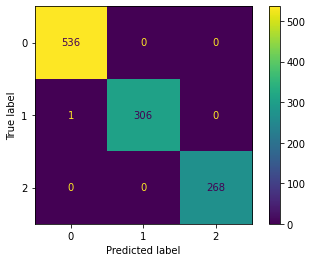

In [67]:
#Creating a confusion matrix for the Building number predictions
confusion_matrix_BUILDING_predictions = confusion_matrix(valid_df_reg['BUILDINGID'], Building_predictions)
#Changing the display
CMDisplay_BUILDING_Predictions=ConfusionMatrixDisplay(confusion_matrix_BUILDING_predictions)
CMDisplay_BUILDING_Predictions.plot()

Now, we will add our building predictions to our validation set, and use this to predict the floor number. It's important to remeber that any errors here will be carried forward, and can cause larger errors further down the line.

In [68]:
#Adding the building predictions to the validation dataset
valid_df_results_wifi_Build = valid_df_results_wifi.iloc[:,:520].merge(pd.Series(Building_predictions,name='BUILDINGID'), left_index=True,right_index=True)

#Soting the floor predictions
Floor_predictions = model_RF_FLOOR.predict(valid_df_results_wifi_Build)

We have an accuracy of ~90% which is quite high given there is a 20% of guessing 0-4 and a 42% chance of guessing Floor 1 (462/1111).

In [69]:
print(classification_report(valid_df_reg['FLOOR'], Floor_predictions))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       132
           1       0.96      0.89      0.92       462
           2       0.85      0.95      0.90       306
           3       0.86      0.96      0.91       172
           4       0.97      0.72      0.82        39

    accuracy                           0.91      1111
   macro avg       0.92      0.88      0.89      1111
weighted avg       0.92      0.91      0.91      1111



In the below we see the most errors where the model has predicted Floor 2, but it is actually floor 1 - this accounts for a high percentage of the errors. As previously discussed, any errors here could affect the longitude and latitdue predictions going forward.

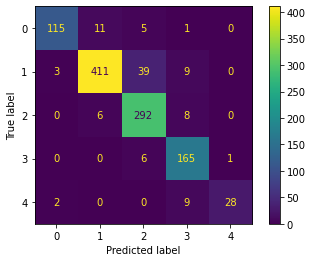

In [70]:
#Confusion matrix for FLoor predictions
confusion_matrix_FLOOR_predictions = confusion_matrix(valid_df_reg['FLOOR'], Floor_predictions)
#Changing display
CMDisplay_FLOOR_Predictions=ConfusionMatrixDisplay(confusion_matrix_FLOOR_predictions)
CMDisplay_FLOOR_Predictions.plot()

In [71]:
#Adding the predicted Floor values to the dataset
valid_df_results_wifi_Build_Floor = valid_df_results_wifi_Build.merge(pd.Series(Floor_predictions,name='FLOOR'), left_index=True,right_index=True)

#Adding the real long&lat results to compare against the models predictions later
valid_df_results_wifi_Build_Floor_long_lat= valid_df_results_wifi_Build_Floor.merge(lat_long_results, left_index=True,right_index=True)

Now we have our dataset, valid_df_results_wifi_Build_Floor, with the predicted Building ID and Floor ID from the strength of the 520 wifi signals in each reading. We will now run a regression model on this dataset to predict the Longitude and Latitude at each reading.

In [72]:
#Splitting the predicted BuildingID and Floor datasets by building to fit the regression models formats (no BUILDINGID)
B0_reg_prediction = valid_df_results_wifi_Build_Floor[valid_df_results_wifi_Build_Floor['BUILDINGID']== 0]
B1_reg_prediction = valid_df_results_wifi_Build_Floor[valid_df_results_wifi_Build_Floor['BUILDINGID']== 1]
B2_reg_prediction = valid_df_results_wifi_Build_Floor[valid_df_results_wifi_Build_Floor['BUILDINGID']== 2]

#Removing Building ID column to fit regression models
B0_reg_prediction=B0_reg_prediction.drop(columns=['BUILDINGID'])
B1_reg_prediction=B1_reg_prediction.drop(columns=['BUILDINGID'])
B2_reg_prediction=B2_reg_prediction.drop(columns=['BUILDINGID'])

#These contain the predicted BUILDINGID and FLOOR values, as well as the correct BUILDINGID, FLOOR, LONGITUDE and LATITUDE
B0_reg_results = valid_df_results_wifi_Build_Floor_long_lat[valid_df_results_wifi_Build_Floor_long_lat['BUILDINGID_x']== 0]
B1_reg_results = valid_df_results_wifi_Build_Floor_long_lat[valid_df_results_wifi_Build_Floor_long_lat['BUILDINGID_x']== 1]
B2_reg_results = valid_df_results_wifi_Build_Floor_long_lat[valid_df_results_wifi_Build_Floor_long_lat['BUILDINGID_x']== 2]

### Predictions

In [73]:
#KN predictions
B0_long_prediction_KN = model_KN_reg_b0_long.predict(B0_reg_prediction)
B0_lat_prediction_KN = model_KN_reg_b0_lat.predict(B0_reg_prediction)
B1_long_prediction_KN = model_KN_reg_b1_long.predict(B1_reg_prediction)
B1_lat_prediction_KN = model_KN_reg_b1_lat.predict(B1_reg_prediction)
B2_long_prediction_KN = model_KN_reg_b2_long.predict(B2_reg_prediction)
B2_lat_prediction_KN = model_KN_reg_b2_lat.predict(B2_reg_prediction)

#Random Forest Predictions
B0_long_prediction_RF = model_RF_reg_b0_long.predict(B0_reg_prediction)
B0_lat_prediction_RF = model_RF_reg_b0_lat.predict(B0_reg_prediction)
B1_long_prediction_RF = model_RF_reg_b1_long.predict(B1_reg_prediction)
B1_lat_prediction_RF = model_RF_reg_b1_lat.predict(B1_reg_prediction)
B2_long_prediction_RF = model_RF_reg_b2_long.predict(B2_reg_prediction)
B2_lat_prediction_RF = model_RF_reg_b2_lat.predict(B2_reg_prediction)



Now we can compare our Long/Lat predictions with the actual Long/Lat from the validation set.

In [74]:
#Creating a dictionary for each Building which we will use to compare results
compare_dict_b0={'Real Longitude':np.array(B0_reg_results['LONGITUDE']),
              'Predicted KN Longitude':np.array(B0_long_prediction_KN),
            'Predicted RF Longitude':np.array(B0_long_prediction_RF),
              'Real Latitude': np.array(B0_reg_results['LATITUDE']), 
              'Predicted KN Latitude':np.array(B0_lat_prediction_KN),
                'Predicted RF Latitude':np.array(B0_lat_prediction_RF)}

compare_dict_b1={'Real Longitude':np.array(B1_reg_results['LONGITUDE']),
              'Predicted KN Longitude':np.array(B1_long_prediction_KN),
            'Predicted RF Longitude':np.array(B1_long_prediction_RF),
              'Real Latitude': np.array(B1_reg_results['LATITUDE']), 
              'Predicted KN Latitude':np.array(B1_lat_prediction_KN),
                'Predicted RF Latitude':np.array(B1_lat_prediction_RF)}
compare_dict_b2={'Real Longitude':np.array(B2_reg_results['LONGITUDE']),
              'Predicted KN Longitude':np.array(B2_long_prediction_KN),
            'Predicted RF Longitude':np.array(B2_long_prediction_RF),
              'Real Latitude': np.array(B2_reg_results['LATITUDE']), 
              'Predicted KN Latitude':np.array(B2_lat_prediction_KN),
                'Predicted RF Latitude':np.array(B2_lat_prediction_RF)}

#Creating the dataframes
b0_comp= pd.DataFrame.from_dict(compare_dict_b0)
b1_comp= pd.DataFrame.from_dict(compare_dict_b1)
b2_comp= pd.DataFrame.from_dict(compare_dict_b2)

#Computing the errors
b0_comp['Longitude KN Error'] = b0_comp['Real Longitude'] - b0_comp['Predicted KN Longitude']
b0_comp['Latitude KN Error'] = b0_comp['Real Latitude'] - b0_comp['Predicted KN Latitude']
b0_comp['Longitude RF Error'] = b0_comp['Real Longitude'] - b0_comp['Predicted RF Longitude']
b0_comp['Latitude RF Error'] = b0_comp['Real Latitude'] - b0_comp['Predicted RF Latitude']

b1_comp['Longitude KN Error'] = b1_comp['Real Longitude'] - b1_comp['Predicted KN Longitude']
b1_comp['Latitude KN Error'] = b1_comp['Real Latitude'] - b1_comp['Predicted KN Latitude']
b1_comp['Longitude RF Error'] = b1_comp['Real Longitude'] - b1_comp['Predicted RF Longitude']
b1_comp['Latitude RF Error'] = b1_comp['Real Latitude'] - b1_comp['Predicted RF Latitude']

b2_comp['Longitude KN Error'] = b2_comp['Real Longitude'] - b2_comp['Predicted KN Longitude']
b2_comp['Latitude KN Error'] = b2_comp['Real Latitude'] - b2_comp['Predicted KN Latitude']
b2_comp['Longitude RF Error'] = b2_comp['Real Longitude'] - b2_comp['Predicted RF Longitude']
b2_comp['Latitude RF Error'] = b2_comp['Real Latitude'] - b2_comp['Predicted RF Latitude']

Text(0.5, 1.0, 'Building 0 K Nearest Neighbours Predicted Values')

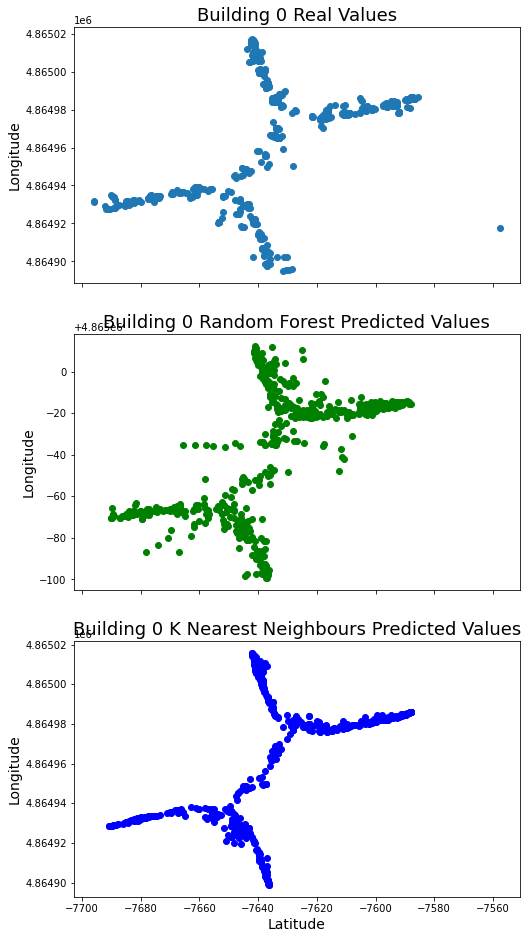

In [75]:
fig, (axb01,axb02,axb03) = plt.subplots(nrows=3,ncols=1,figsize = (8,16), sharex = True)
#fonts
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}

#x axis
plt.xlabel('Latitude',fontdict = fontdict_yaxis)

axb01.plot(b0_comp['Real Longitude'],b0_comp['Real Latitude'],'o')
axb01.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb01.set_title('Building 0 Real Values', fontdict= fontdict);

axb02.plot(b0_comp['Predicted RF Longitude'],b0_comp['Predicted RF Latitude'],'go')
axb02.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb02.set_title('Building 0 Random Forest Predicted Values', fontdict= fontdict);

axb03.plot(b0_comp['Predicted KN Longitude'],b0_comp['Predicted KN Latitude'],'bo')
axb03.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb03.set_title('Building 0 K Nearest Neighbours Predicted Values', fontdict= fontdict)

K Nearest Neighbours looks very similar to the actual plot in Building 0, with a high level of accruacy.

Text(0.5, 1.0, 'Building 1 K Nearest Neighbours Predicted Values')

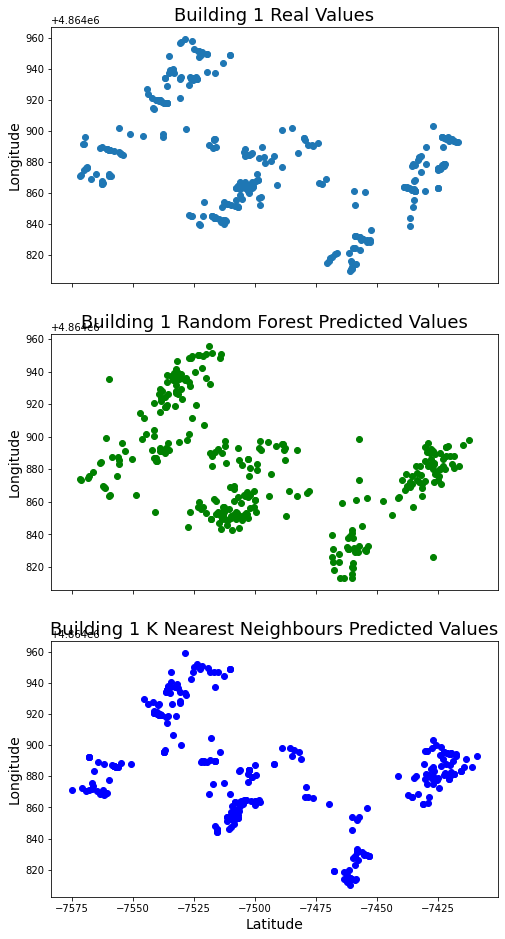

In [76]:
fig, (axb11,axb12,axb13) = plt.subplots(nrows=3,ncols=1,figsize = (8,16), sharex = True)
#fonts
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}
plt.xlabel('Latitude',fontdict = fontdict_yaxis)

axb11.plot(b1_comp['Real Longitude'],b1_comp['Real Latitude'],'o')
axb11.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb11.set_title('Building 1 Real Values', fontdict= fontdict);

axb12.plot(b1_comp['Predicted RF Longitude'],b1_comp['Predicted RF Latitude'],'go')
axb12.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb12.set_title('Building 1 Random Forest Predicted Values', fontdict= fontdict);

axb13.plot(b1_comp['Predicted KN Longitude'],b1_comp['Predicted KN Latitude'],'bo')
axb13.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb13.set_title('Building 1 K Nearest Neighbours Predicted Values', fontdict= fontdict)

Building 1 is a bit less conclusive, both models resemble the original image which is not as defined as building 0.

Text(0.5, 1.0, 'Building 2 K Nearest Neighbours Predicted Values')

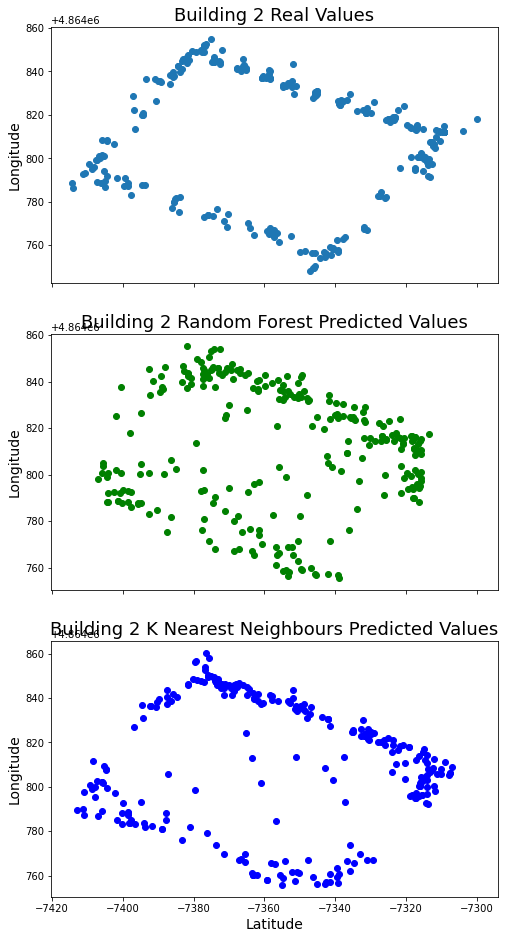

In [77]:
fig, (axb21,axb22,axb23) = plt.subplots(nrows=3,ncols=1,figsize = (8,16), sharex = True)
#fonts
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}
plt.xlabel('Latitude',fontdict = fontdict_yaxis)

axb21.plot(b2_comp['Real Longitude'],b2_comp['Real Latitude'],'o')
axb21.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb21.set_title('Building 2 Real Values', fontdict= fontdict);

axb22.plot(b2_comp['Predicted RF Longitude'],b2_comp['Predicted RF Latitude'],'go')
axb22.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb22.set_title('Building 2 Random Forest Predicted Values', fontdict= fontdict);

axb23.plot(b2_comp['Predicted KN Longitude'],b2_comp['Predicted KN Latitude'],'bo')
axb23.set_ylabel('Longitude', fontdict = fontdict_yaxis); 
axb23.set_title('Building 2 K Nearest Neighbours Predicted Values', fontdict= fontdict)

K Nearest again looks to have performed better here, with the outline more defined than RF.

Text(0, 0.5, 'Longitude (meters from value)')

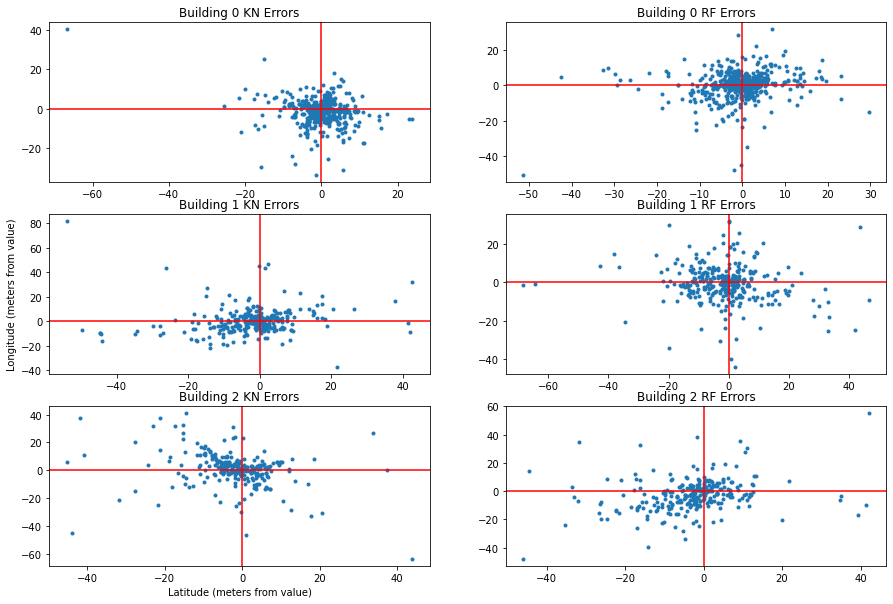

In [78]:
#Creating a dashboard of all the error plots
fig,((axsB00,axsB01),(axsB10,axsB11),(axsB20,axsB21))=plt.subplots(nrows=3,ncols=2,figsize=(15,10))

#font size
fontdict = {'fontsize': 18}
fontdict_yaxis = {'fontsize': 14}

axsB00.scatter(b0_comp['Latitude KN Error'], b0_comp['Longitude KN Error'],marker=".")
axsB00.set_title('Building 0 KN Errors')
axsB01.scatter(b0_comp['Latitude RF Error'],-b0_comp['Longitude RF Error'],marker=".")
axsB01.set_title('Building 0 RF Errors')

axsB10.scatter(b1_comp['Latitude KN Error'], b1_comp['Longitude KN Error'],marker=".")
axsB10.set_title('Building 1 KN Errors')
axsB11.scatter(b1_comp['Latitude RF Error'],-b1_comp['Longitude RF Error'],marker=".")
axsB11.set_title('Building 1 RF Errors')

axsB20.scatter(b2_comp['Latitude KN Error'], b2_comp['Longitude KN Error'],marker=".")
axsB20.set_title('Building 2 KN Errors')
axsB21.scatter(b2_comp['Latitude RF Error'],-b2_comp['Longitude RF Error'],marker=".")
axsB21.set_title('Building 2 RF Errors')

axsB00.axhline(y=0,color='r', linestyle='-')
axsB00.axvline(x=0,color='r', linestyle='-')
axsB01.axhline(y=0,color='r', linestyle='-')
axsB01.axvline(x=0,color='r', linestyle='-')
axsB10.axhline(y=0,color='r', linestyle='-')
axsB10.axvline(x=0,color='r', linestyle='-')
axsB11.axhline(y=0,color='r', linestyle='-')
axsB11.axvline(x=0,color='r', linestyle='-')
axsB20.axhline(y=0,color='r', linestyle='-')
axsB20.axvline(x=0,color='r', linestyle='-')
axsB21.axhline(y=0,color='r', linestyle='-')
axsB21.axvline(x=0,color='r', linestyle='-')

axsB20.set_xlabel('Latitude (meters from value)')
axsB10.set_ylabel('Longitude (meters from value)')

Most of the errors in Building 0 are within 20 meters in longitude and latitude, with KN perhaps having a tighter nucleus.

KN errors are more condensed around the (0,0) center than RF for Building 1.

Building 2 RF looks to have slightly more accurate with more points closer to the center than KN.

### Error comparisons

In [152]:
#Error Metrics

#Building 0
#RF
RF_long_b0_validation_errors=[mean_absolute_error(b0_comp['Real Longitude'], b0_comp['Predicted RF Longitude']),r2_score(b0_comp['Real Longitude'], b0_comp['Predicted RF Longitude']),mean_squared_error(b0_comp['Real Longitude'], b0_comp['Predicted RF Longitude']),
               mean_squared_error(b0_comp['Real Longitude'], b0_comp['Predicted RF Longitude'],squared=False)]
RF_lat_b0_validation_errors=[mean_absolute_error(b0_comp['Real Latitude'], b0_comp['Predicted RF Latitude']),r2_score(b0_comp['Real Latitude'], b0_comp['Predicted RF Latitude']),mean_squared_error(b0_comp['Real Latitude'], b0_comp['Predicted RF Latitude']),
               mean_squared_error(b0_comp['Real Latitude'], b0_comp['Predicted RF Latitude'],squared=False)]
#KN
KN_long_b0_validation_errors=[mean_absolute_error(b0_comp['Real Longitude'], b0_comp['Predicted KN Longitude']),r2_score(b0_comp['Real Longitude'], b0_comp['Predicted KN Longitude']),mean_squared_error(b0_comp['Real Longitude'], b0_comp['Predicted KN Longitude']),
               mean_squared_error(b0_comp['Real Longitude'], b0_comp['Predicted KN Longitude'],squared=False)]
KN_lat_b0_validation_errors=[mean_absolute_error(b0_comp['Real Latitude'], b0_comp['Predicted KN Latitude']),r2_score(b0_comp['Real Latitude'], b0_comp['Predicted KN Latitude']),mean_squared_error(b0_comp['Real Latitude'], b0_comp['Predicted KN Latitude']),
               mean_squared_error(b0_comp['Real Latitude'], b0_comp['Predicted KN Latitude'],squared=False)]

#Building 1
#RF
RF_long_b1_validation_errors=[mean_absolute_error(b1_comp['Real Longitude'], b1_comp['Predicted RF Longitude']),r2_score(b1_comp['Real Longitude'], b1_comp['Predicted RF Longitude']),mean_squared_error(b1_comp['Real Longitude'], b1_comp['Predicted RF Longitude']),
               mean_squared_error(b1_comp['Real Longitude'], b1_comp['Predicted RF Longitude'],squared=False)]
RF_lat_b1_validation_errors=[mean_absolute_error(b1_comp['Real Latitude'], b1_comp['Predicted RF Latitude']),r2_score(b1_comp['Real Latitude'], b1_comp['Predicted RF Latitude']),mean_squared_error(b1_comp['Real Latitude'], b1_comp['Predicted RF Latitude']),
               mean_squared_error(b1_comp['Real Latitude'], b1_comp['Predicted RF Latitude'],squared=False)]
#KN
KN_long_b1_validation_errors=[mean_absolute_error(b1_comp['Real Longitude'], b1_comp['Predicted KN Longitude']),r2_score(b1_comp['Real Longitude'], b1_comp['Predicted KN Longitude']),mean_squared_error(b1_comp['Real Longitude'], b1_comp['Predicted KN Longitude']),
               mean_squared_error(b1_comp['Real Longitude'], b1_comp['Predicted KN Longitude'],squared=False)]
KN_lat_b1_validation_errors=[mean_absolute_error(b1_comp['Real Latitude'], b1_comp['Predicted KN Latitude']),r2_score(b1_comp['Real Latitude'], b1_comp['Predicted KN Latitude']),mean_squared_error(b1_comp['Real Latitude'], b1_comp['Predicted KN Latitude']),
               mean_squared_error(b1_comp['Real Latitude'], b1_comp['Predicted KN Latitude'],squared=False)]

#Building 2
#RF
RF_long_b2_validation_errors=[mean_absolute_error(b2_comp['Real Longitude'], b2_comp['Predicted RF Longitude']),r2_score(b2_comp['Real Longitude'], b2_comp['Predicted RF Longitude']),mean_squared_error(b2_comp['Real Longitude'], b2_comp['Predicted RF Longitude']),
               mean_squared_error(b2_comp['Real Longitude'], b2_comp['Predicted RF Longitude'],squared=False)]
RF_lat_b2_validation_errors=[mean_absolute_error(b2_comp['Real Latitude'], b2_comp['Predicted RF Latitude']),r2_score(b2_comp['Real Latitude'], b2_comp['Predicted RF Latitude']),mean_squared_error(b2_comp['Real Latitude'], b2_comp['Predicted RF Latitude']),
               mean_squared_error(b2_comp['Real Latitude'], b2_comp['Predicted RF Latitude'],squared=False)]
#KN
KN_long_b2_validation_errors=[mean_absolute_error(b2_comp['Real Longitude'], b2_comp['Predicted KN Longitude']),r2_score(b2_comp['Real Longitude'], b2_comp['Predicted KN Longitude']),mean_squared_error(b2_comp['Real Longitude'], b2_comp['Predicted KN Longitude']),
               mean_squared_error(b2_comp['Real Longitude'], b2_comp['Predicted KN Longitude'],squared=False)]
KN_lat_b2_validation_errors=[mean_absolute_error(b2_comp['Real Latitude'], b2_comp['Predicted KN Latitude']),r2_score(b2_comp['Real Latitude'], b2_comp['Predicted KN Latitude']),mean_squared_error(b2_comp['Real Latitude'], b2_comp['Predicted KN Latitude']),
               mean_squared_error(b2_comp['Real Latitude'], b2_comp['Predicted KN Latitude'],squared=False)]

In [153]:
#Defining the labels for error comparison
reg_model=['Random Forest','K Nearest Neighbours']
error_stat=['MAE','R Squared', 'MSE','RMSE']

df_valid_error_validation_b0_lat=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_valid_error_validation_b0_long=pd.DataFrame(columns=reg_model, index=error_stat
                        )

df_valid_error_validation_b1_lat=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_valid_error_validation_b1_long=pd.DataFrame(columns=reg_model, index=error_stat
                        )

df_valid_error_validation_b2_lat=pd.DataFrame(columns=reg_model, index=error_stat
                        )
df_valid_error_validation_b2_long=pd.DataFrame(columns=reg_model, index=error_stat
                        )

#Building 0
df_valid_error_validation_b0_lat['Random Forest']=RF_lat_b0_validation_errors
df_valid_error_validation_b0_lat['K Nearest Neighbours'] = KN_lat_b0_validation_errors

df_valid_error_validation_b0_long['Random Forest']=RF_long_b0_validation_errors
df_valid_error_validation_b0_long['K Nearest Neighbours'] = KN_long_b0_validation_errors

df_valid_error_validation_b1_lat['Random Forest']=RF_lat_b1_validation_errors
df_valid_error_validation_b1_lat['K Nearest Neighbours'] = KN_lat_b1_validation_errors

df_valid_error_validation_b1_long['Random Forest']=RF_long_b1_validation_errors
df_valid_error_validation_b1_long['K Nearest Neighbours'] = KN_long_b1_validation_errors

#Building 2
df_valid_error_validation_b2_lat['Random Forest']=RF_lat_b2_validation_errors
df_valid_error_validation_b2_lat['K Nearest Neighbours'] = KN_lat_b2_validation_errors

df_valid_error_validation_b2_long['Random Forest']=RF_long_b2_validation_errors
df_valid_error_validation_b2_long['K Nearest Neighbours'] = KN_long_b2_validation_errors

#### Building 0

In [154]:
print("Error Metrics for validation set Latitude predictions in Building 0:")
df_valid_error_validation_b0_lat

,Random Forest,K Nearest Neighbours
MAE,4.700397,3.526988
R Squared,0.944857,0.965441
MSE,56.115324,35.168357
RMSE,7.491016,5.930292


In [155]:
print("Error Metrics for validation set Longitude predictions in Building 0:")
df_valid_error_validation_b0_long

,Random Forest,K Nearest Neighbours
MAE,4.911700,4.017717
R Squared,0.914506,0.941721
MSE,59.174094,40.337393
RMSE,7.692470,6.351173


#### Building 1

In [154]:
print("Error Metrics for validation set Latitude predictions in Building 1:")
df_valid_error_validation_b1_lat

,Random Forest,K Nearest Neighbours
MAE,4.700397,3.526988
R Squared,0.944857,0.965441
MSE,56.115324,35.168357
RMSE,7.491016,5.930292


In [158]:
print("Error Metrics for validation set Longitude predictions in Building 1c:")
df_valid_error_validation_b1_long

Error Metrics for validation set Longitude predictions in Building 1c:


,Random Forest,K Nearest Neighbours
MAE,7.131037,6.568645
R Squared,0.950580,0.946005
MSE,103.070937,112.611892
RMSE,10.152386,10.611875


#### Building 2

In [157]:
print("Error Metrics for validation set Latitude predictions in Building 2:")
df_valid_error_validation_b2_lat

Error Metrics for validation set Latitude predictions in Building 2:


,Random Forest,K Nearest Neighbours
MAE,8.045274,6.824960
R Squared,0.827394,0.866449
MSE,140.258341,108.522868
RMSE,11.843071,10.417431


In [156]:
print("Error Metrics for validation set Longitude predictions in Building 2:")
df_valid_error_validation_b2_long

Error Metrics for validation set Longitude predictions in Building 2:


,Random Forest,K Nearest Neighbours
MAE,8.370941,7.788749
R Squared,0.859774,0.850385
MSE,138.135699,147.384414
RMSE,11.753114,12.140198


## Model optimisation

I will try to improve results by tuning the hyperparameters in one of our worst performing models, 

In [82]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(indep_var_regression_long_b2_train,dep_var_regression_long_b2_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

RandomizedSearchCV
RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [88]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [87]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

In [113]:
best_random = rf_random.best_estimator_
best_random_predict= best_random.predict(B2_reg_prediction)

We can now use a grid search to find other options for model optimisation

In [165]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid_2 = {'n_estimators': [400,800], #Number of trees
 'min_samples_split': [2,5,10],
 'min_samples_leaf': [1,2,3],
 'max_features': ['auto','sqrt'], #Maximum number of features to be selected sqrt = sqrt(n_features)
 'max_depth': [None,50,100], #maximum number of nodes in a tree,
 'bootstrap': [True,False]} #Whether to include bootstrap samples
# Create a based model
rf_2 = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_2, param_grid = param_grid_2, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [166]:
grid_search.fit(indep_var_regression_long_b2_test,dep_var_regression_long_b2_test)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [400, 800]},
             verbose=2)

In [167]:
best_grid = grid_search.best_estimator_
grid_predicts = best_grid.predict(B2_reg_prediction)

In [168]:
b2_long_optimised = b2_comp.copy()
b2_long_optimised= b2_long_optimised[['Real Longitude','Predicted RF Longitude']]
b2_long_optimised['RF Grid Predictions'] = grid_predicts
b2_long_optimised['RF Random Predictions'] = best_random_predict

RF_long_b2_grid_search_errors=[mean_absolute_error(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Grid Predictions']),r2_score(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Grid Predictions']),mean_squared_error(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Grid Predictions']),
               mean_squared_error(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Grid Predictions'],squared=False)]
RF_long_b2_random_search_errors=[mean_absolute_error(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Random Predictions']),r2_score(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Random Predictions']),mean_squared_error(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Random Predictions']),
               mean_squared_error(b2_long_optimised['Real Longitude'], b2_long_optimised['RF Random Predictions'],squared=False)]
RF_long_b2_orginal_errors=[mean_absolute_error(b2_long_optimised['Real Longitude'], b2_long_optimised['Predicted RF Longitude']),r2_score(b2_long_optimised['Real Longitude'], b2_long_optimised['Predicted RF Longitude']),mean_squared_error(b2_long_optimised['Real Longitude'], b2_long_optimised['Predicted RF Longitude']),
               mean_squared_error(b2_long_optimised['Real Longitude'], b2_long_optimised['Predicted RF Longitude'],squared=False)]


In [169]:
#Creating a dataframe to compare the errors across all models.
models_list_new=['Original Model', 'Random Search Model', 'Grid Search model']

df_error_comp_long_b2_opt=pd.DataFrame(columns=models_list_new, index=error_stat)

df_error_comp_long_b2_opt['Original Model']= RF_long_b2_orginal_errors
df_error_comp_long_b2_opt['Random Search Model'] = RF_long_b2_random_search_errors
df_error_comp_long_b2_opt['Grid Search model'] = RF_long_b2_grid_search_errors

print('We can compare Error Metrics for our Random Forest regression models predicting longitude and latitude in our ')
df_error_comp_long_b2_opt

We can compare Error Metrics for our Random Forest regression models predicting longitude and latitude in our 


,Original Model,Random Search Model,Grid Search model
MAE,8.370941,8.743676,9.320145
R Squared,0.859774,0.865220,0.852118
MSE,138.135699,132.771094,145.677726
RMSE,11.753114,11.522634,12.069703


In [170]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400)

As we can see above, tuning the hyper parameters according to the Random Search best estimator: RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=400) has resulted in a smaller RMSE, and a R squared value closer to 1 which implies we have improved our model accuracy.
